In [1]:
%matplotlib inline

# Signal processing with GWpy part 1: the frequency domain

A quick (code only) recap of what we have learned:

['https://www.gw-osc.org/catalog/GWTC-1-confident/data/GW170817/H-H1_GWOSC_4KHZ_R1-1187008867-32.hdf5']
Fetched 1 URLs from www.gw-osc.org for [1187008877 .. 1187008887))
Reading data... [Done]


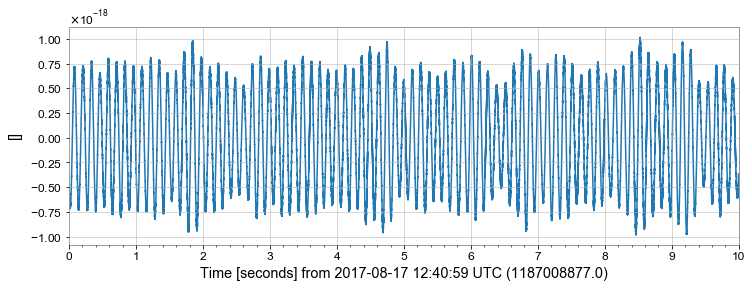

In [3]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW170817')
igps = int(gps)
segment = (igps - 5, igps + 5)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)
plot = hdata.plot()

Now, this plot doesn't tell us very much, and we definitely can't see any gravitational waves in there.
This is where signal processing becomes extremely important, and is vital to any analysis of these data.

## Studying data in the frequency domain using the Fourier transform

The [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) is a widely-used mathematical tool to expose the frequency-domain content of a time-domain signal, meaning we can see which frequencies contian lots of power, and which have less.

We can calculate the Fourier transform of our `TimeSeries` using the [`fft()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.fft) method:

In [4]:
fft = hdata.fft()
print(fft)

FrequencySeries([-2.72463909e-21+0.00000000e+00j,
                 -5.94400493e-21+2.02357335e-21j,
                 -3.37963767e-21+3.26934867e-21j, ...,
                 -2.20636733e-24-1.09472069e-25j,
                 -2.20276854e-24-6.87966235e-26j,
                 -2.08873413e-24+0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.1 Hz,
                epoch: 1187008877.0,
                name: Strain,
                channel: None,
                frequencies: None)


The result is a [`FrequencySeries`](https://gwpy.github.io/docs/stable/frequencyseries/), with complex amplitude, representing the amplitude and phase of each frequency in our data.
We can use `abs()` to extract the amplitude and plot that:

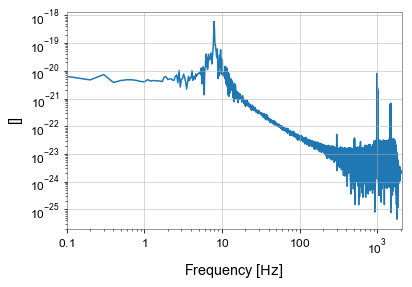

In [6]:
plot = fft.abs().plot(xscale="log", yscale="log")
plot.show()

This doesn't look correct at all!
The problem is that the FFT works under the assumption that our data are periodic, which means that the edges of our data look like discontinuities when transformed.
We need to apply a window function to our time-domain data before transforming, which we can do using the [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html) module:

In [7]:
from scipy.signal import get_window
window = get_window('hann', hdata.size)
hwin = hdata * window

Let's try our transform again and see what we get

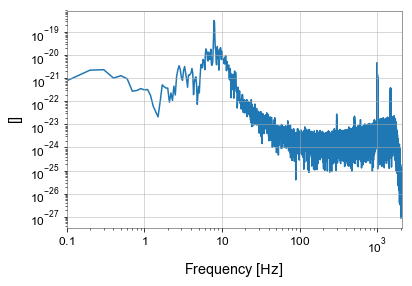

In [9]:
fftamp = hwin.fft().abs()
plot = fftamp.plot(xscale="log", yscale="log")
plot.show()

This looks a little more like what we expect for the amplitude spectral density of a gravitational-wave detector.

## Calculating the power spectral density

In practice, we typically use a large number of FFTs to estimate an averages power spectral density over a long period of data.
We can do this using the [`asd()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.asd) method, which uses [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method) to combine FFTs of overlapping, windowed chunks of data.

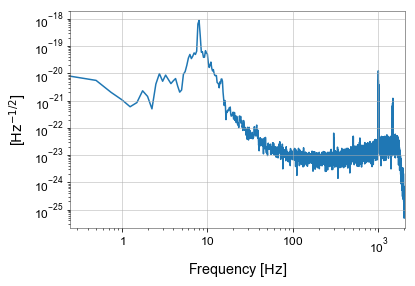

In [16]:
asd = hdata.asd(fftlength=4, method="median")
plot = asd.plot()
plot.show()

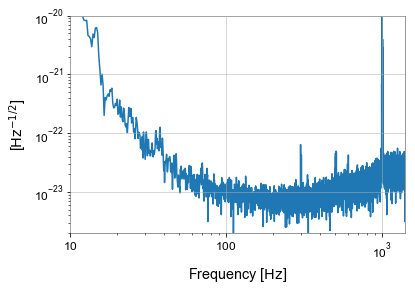

In [17]:
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(2e-24, 1e-20)
plot

The ASD is a standard tool used to study the frequency-domain sensitivity of a gravitational-wave detector.
For the LIGO-Hanford data we loaded, we can see large spikes at certain frequencies, including

- ~300 Hz
- ~500 Hz
- ~1000 Hz

The [O2 spectral lines](https://www.gw-openscience.org/o2speclines/) page on GWOSC describes a number of these spectral features for O2, with some of them being forced upon us, and some being deliberately introduced to help with interferometer control.

Loading more data allows for more FFTs to be averaged during the ASD calculation, meaning random variations get averaged out, and we can see more detail:

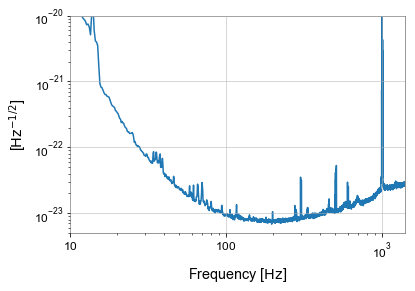

In [18]:
hdata2 = TimeSeries.fetch_open_data('H1', igps-512, igps+512, cache=True)
hasd2 = hdata2.asd(fftlength=4, method="median")
plot = hasd2.plot()
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(5e-24, 1e-20)
plot.show()

Now we can see some more features, including sets of lines around ~30 Hz and ~65 Hz, and some more isolate lines through the more sensitive region.

For comparison, we can load the LIGO-Livingston data and plot that as well:

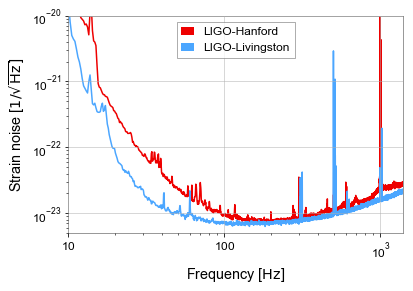

In [19]:
# get Livingston data
ldata2 = TimeSeries.fetch_open_data('L1', igps-512, igps+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")

# and plot using standard colours
ax.plot(lasd2, label='LIGO-Livingston', color='gwpy:ligo-livingston')

# update the Hanford line to use standard colour, and have a label
hline = ax.lines[0]
hline.set_color('gwpy:ligo-hanford')  # change colour of Hanford data
hline.set_label('LIGO-Hanford')

ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
plot

Now we can see clearly the relative sensitivity of each LIGO instrument, the common features between both, and those unique to each observatory.